In [8]:
%matplotlib inline

from pylab import *
from matplotlib import pyplot as pl

## The Cox-Ingersoll-Ross SDE and Its Simulation

##### from Yves Hilpisch "Derivatives Analytics with Python" Wiley Finance (2015)
You cannot miss to visit his [web site](http://pythonquants.com/)!!! 

<img src="http://hilpisch.com/images/derivatives_analytics_front.jpg" alt="Derivatives Analytics with Python" width="10%" align="left" border="0">


<img src="img/tpq_logo.png" alt="" width="10%" align="left" border="0">

### Path Generation

In this section, we consider the stochastic short rate model MCIR85 of Cox- Ingersoll-Ross which is given by the SDE: 

\begin{equation}
dr_t = \kappa_r (\theta_r - r_t) dt + \sigma_r \sqrt{r_t} dZ_t
\end{equation}

To simulate the short rate model, it has to be discretized. To this end, we  divide the given time interval $[0, T ]$ in equidistant sub-intervals of length  $t$ such that now $t \in \{0,  \Delta t, 2 \Delta t, \dots, T \}$, i.e. there are $M + 1$ points in time with $M = T/t$.

The exact transition law of the square-root diffusion is known. [This paper](http://www.columbia.edu/~mnb2/broadie/Assets/broadie_kaya_exact_sim_or_2006.pdf) provides an in-depth analysis of this topic. Consider the general square- root diffusion process

$$
dx_t = \kappa (\theta - x_t) dt + \sigma \sqrt{x_t} dZ_t \quad \quad [1]
$$

In [Broadie et. al.](http://www.columbia.edu/~mnb2/broadie/Assets/broadie_kaya_exact_sim_or_2006.pdf) it is shown that $x_t$, given $x_s$ with $s = t - \Delta t$, is distributed according to

$$ 
x_t = \frac{\sigma^2 (1 - e^{-\kappa \Delta t})}{4\kappa} \chi^{\prime 2}_d \left( \frac{4^{-\kappa\Delta t}}{\sigma^2(1-e^{-\kappa \Delta t})} x_s \right)
$$

where  $\chi^{\prime 2}_d$ denotes a non-central chi-squared random variable with

$$d=\frac{4\theta \kappa}{\sigma^2}$$

degrees of freedom and non-centrality parameter

$$l= \frac{4^{-\kappa\Delta t}}{\sigma^2(1-e^{-\kappa \Delta t})} x_s $$

For implementation purposes, it may be convenient to sample a chi-squared
random variable  $\chi^2_d$ instead of a non-central chi-squared one,  $\chi^{\prime 2}_d$. 
If $d > 1$, the following relationship holds true
$$
\chi^{\prime 2}_d (l) = (z + \sqrt{l})^2 + \chi^2_{d-1}
$$

where $z$ is an independent standard normally distributed random variable. Similarly, if $d \le 1$, one has 

$$
\chi^{\prime 2}_d (l) = \chi^2_{d+2N}
$$

where $N$ is now a Poisson-distributed random variable with intensity $l/2$. For an algorithmic representation of this simulation scheme refer to *Glasserman*, p. 124.



This is the function which generate paths according to the CIR models without approximations. The input parameters are: 
* x0: (float) initial value
* kappa: (float) mean-reversion factor
* theta: (float) long-run mean
* sigma: (float) volatility factor
* T: (float) final date/time horizon
* M: (int) number of time steps
* I: (int) number of paths
 
This function returns a NumPy array containing the simulated paths.

In [9]:
def CIR_generate_paths_exact(x0, kappa, theta, sigma, T, M, I):
    
    dt    = T / M
    x     = np.zeros((M + 1, I), dtype=np.float)
    x[0]  = x0
    xh    = np.zeros_like(x)
    xh[0] = x0
    ran   = np.random.standard_normal((M + 1, I))

    d = 4 * kappa * theta / sigma ** 2
    c = (sigma ** 2 * (1 - math.exp(-kappa * dt))) / (4 * kappa)
    if d > 1:
        for t in xrange(1, M + 1):
            l = x[t - 1] * math.exp(-kappa * dt) / c
            chi = np.ramdom.chisquare(d - 1, I)
            x[t] = c * ((ran[t] + np.sqrt(l)) ** 2 + chi)
    else:
        for t in xrange(1, M + 1):
            l = x[t - 1] * math.exp(-kappa * dt) / c
            N = np.random.poisson(l / 2, I)
            chi = np.random.chisquare(d + 2 * N, I)
            x[t] = c * chi
    return x


The exactness comes along with a relatively high computational burden which may, however, be justified by higher accuracy due to faster convergence. In other words, although the computational burden per simulated value of xt may be quite high with the exact scheme, the possible reduction in time steps and simulation paths may more than compensate for this.

We also consider an Euler discretization of the square-root diffusion [1]. A possible discretization is given by

$$
x_t = \vert x_s + \kappa (\theta - x_s ) \Delta t + \sigma \sqrt{x_s} \sqrt{\Delta t} z_t \vert
$$

with $z_t$ standard normal. While $x_t$ cannot reach zero with the exact scheme if the Feller condition $2 \kappa \theta > \sigma^2$ is met, this is not the case with the Euler scheme. Therefore, we take the absolute value on the right hand side for $x_t$.

In [10]:
def CIR_generate_paths_approx(x0, kappa, theta, sigma, T, M, I):
    
    dt    = T / M
    x     = np.zeros((M + 1, I), dtype=np.float)
    x[0]  = x0
    xh    = np.zeros_like(x)
    xh[0] = x0
    ran   = np.random.standard_normal((M + 1, I))

    for t in xrange(1, M + 1):
        xh[t] = (xh[t - 1] + kappa * (theta - np.maximum(0, xh[t - 1]))
                    * dt + np.sqrt(np.maximum(0, xh[t - 1]))
                    * sigma * ran[t] * math.sqrt(dt))
        x[t] = np.maximum(0, xh[t])
    return x

Let'us generate some paths...

In [11]:
    #
    # Model Parameters
    #
    r0, kappa_r, theta_r, sigma_r = [0.01, 0.1, 0.03, 0.2]
    T  = 2.0  # time horizon
    M  = 50   # time steps
    dt = T / M
    I  = 50000  # number of MCS paths
    np.random.seed(50000)  # seed for RNG

    r = CIR_generate_paths_exact(r0, kappa_r, theta_r, sigma_r, T, M, I)

The following figure shown a number of simulated paths from the short rate process of CIR.

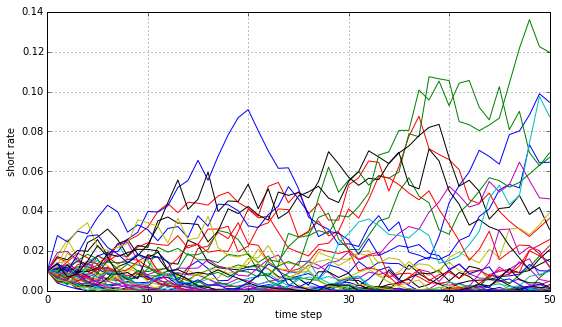

In [12]:
plt.figure(figsize=(9, 5))
plt.plot(range(len(r)), r[:, :50])
plt.grid()
plt.xlabel('time step')
plt.ylabel('short rate')
plt.show()

### Pricing ZCB

A MC estimator for the value of the ZCB at $t$ is derived as follows. Consider a certain path $i$ of the $I$ simulated paths for the short rate process with time grid $t \in \{0,\Delta t, 2\Delta t, \dots, T \}$. We discount the terminal value of the ZCB, i.e. 1, step-by-step backward. For $t < T$ and $s = t - \Delta t$ we have

$$
B_{s,i} = B_{t,i} e^{-\frac{r_t+r_s}{2}\Delta t}
$$

The MC estimator of the ZCB value at $t$ is

$$
B_t^{MC} = \frac{1}{I} \sum\limits_{i=1}^I B_{t,i}
$$

In [13]:
def CIR_generate_paths(r0, kappa_r, theta_r, sigma_r, T, M, I, x_disc):
    if x_disc is 'exact':
        return CIR_generate_paths_exact(r0, kappa_r, theta_r, sigma_r, T, M, I)
    else:
        return CIR_generate_paths_approx(r0, kappa_r, theta_r, sigma_r, T, M, I)
    
def zcb_estimator(M=50, x_disc='exact'):
    dt = T / M
    r = CIR_generate_paths(r0, kappa_r, theta_r, sigma_r, T, M, I, x_disc)
    zcb = np.zeros((M + 1, I), dtype=np.float)
    zcb[-1] = 1.0  # final value
    for t in range(M, 0, -1):
        zcb[t - 1] = zcb[t] * np.exp(-(r[t] + r[t - 1]) / 2 * dt)
    return np.sum(zcb, axis=1) / I

The present value of the ZCB in the CIR model takes the form:

$$
B_0(T) = b_1(T) e^{-b_2(T)r_0}
$$

where 

$$
b_1(T) = \left[
\frac{2\gamma \> exp((\kappa_r + \gamma)T/2)}{2\gamma + (\kappa_r + \gamma)(e^{\gamma T}-1)}
\right]^{\frac{2\kappa_r \theta_r}{\sigma^2_r}}
\quad \quad
b_2(T) = \frac{2(e^{\gamma T} -1)}{2\gamma + (\kappa_r + \gamma)(e^{\gamma T} -1)}
\quad \quad
\gamma = \sqrt{\kappa_r^2 + 2 \sigma^2_r}
$$

The code for the computation of these functions is contained in the file **CIR_zcb_valuation_gen.py**

In [14]:
from CIR_zcb_valuation_gen import B

MCS_values = zcb_estimator(M, 'exact')
CIR_values = []
dt = T / M
t_list = np.arange(0.0, T + 0.001, dt)  # dates of interest
for t in t_list:
    alpha = r0, kappa_r, theta_r, sigma_r, t, T
    CIR_values.append(B(alpha))


ImportError: No module named CIR_zcb_valuation_gen

In [ ]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
ax[0].plot(t_list, MCS_values, 'ro', label='MCS values')
ax[0].plot(t_list, CIR_values, 'b', label='CIR values')
ax[0].legend(loc=0)
ax[0].grid()
ax[0].set_ylim(min(CIR_values) - 0.005, max(CIR_values) + 0.005)
ax[0].set_ylabel('option values')
ax[0].set_title('maturity $T=2$')
ax[1].bar(t_list - 0.025 / 2., MCS_values - CIR_values, 
                    width=0.025)
plt.ylabel('difference')
plt.xlim(min(t_list) - 0.1, max(t_list) + 0.1)
plt.xlabel('time $t$')
plt.tight_layout()
plt.grid()


In [ ]:
MCS_values = zcb_estimator(M, 'approx')

In [ ]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
ax[0].plot(t_list, MCS_values, 'ro', label='MCS values')
ax[0].plot(t_list, CIR_values, 'b', label='CIR values')
ax[0].legend(loc=0)
ax[0].grid()
ax[0].set_ylim(min(CIR_values) - 0.005, max(CIR_values) + 0.005)
ax[0].set_ylabel('option values')
ax[0].set_title('maturity $T=2$')
ax[1].bar(t_list - 0.025 / 2., MCS_values - CIR_values, 
                    width=0.025)
plt.ylabel('difference')
plt.xlim(min(t_list) - 0.1, max(t_list) + 0.1)
plt.xlabel('time $t$')
plt.tight_layout()
plt.grid()

## Bibliography

[1] Yves Hilpisch "Derivatives Analytics with Python", Wiley 2016

[2] Paul Glasserman "Monte Carlo Methods in Financial Engineering", Springer 2004